In [1]:
# packages
import sys
import os
import numpy as np

sys.path.insert(0, os.path.abspath("../ssh-kd"))
from plugin.seg import remove_outliers, helper_object_points
from utils.data_prep import read_file, get_outliers


# hidding the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Clustering
from sklearn.cluster import DBSCAN
def _cluster(X_):
    """ cluster using dbscan.
        params: X_ = list of x,y point
        return: lables
    """
    clustering = DBSCAN(eps=1, min_samples=8).fit(X_)
    labels = clustering.labels_
    return labels

In [3]:
def format_data(df):
    """ format data for cluster input.
        params: df = dataframe with transform _x,_y
        return: numpy array of x,y point
    """
    return np.array(list(zip(np.array(df["_x"]),np.array(df["_y"]))))

In [4]:
def normalize(df):
    """ Normalize the point using min_max normalizer.
        params: df = dataframe with transform _x,_y
        return: df with normalized _x,_y points
    """
    df['_x'] = (df['_x']-df['_x'].min())/(df['_x'].max()-df['_x'].min())
    df['_y'] = (df['_y']-df['_y'].min())/(df['_y'].max()-df['_y'].min())
    return df

In [5]:
def project(df, d, view):
    """ Project with prespective projections.
        formula: x' = x*d/z
                 y' = y*d/z
        params: df = dataframe with with x,y,z points
                d =  distance of prespective projection
                view = w.r.t X , w.r.t Z
        return: df with transformed _x,_y points in df
    """
    v= "X" if view == "X" else "Z"
    z= "X" if view == "Z" else "Z"
    df['_x'] = ((df[z]/df[v])*d)
    df['_y'] = ((df['Y']/df[v])*d)
    return df

In [6]:
def cabin_projection(df,alpha):
    """ Project with cabin projections.
        formula: x' = x + 0.5*cos(alpha)*z
                 y' = y + 0.5*cos(alpha)*z
        params: df = dataframe with with x,y,z points
                alpha =  angle of projection
        return: df with transformed _x,_y points in df
    """
    df['_x'] = (df['X']+(0.5*df['Z'])*np.cos(np.deg2rad(alpha)))
    df['_y'] = (df['Y']+(0.5*df['Z'])*np.sin(np.deg2rad(alpha)))
    return df
    

In [7]:
def get_data(object_type,object,num_scenes):
    """ Load the data from dataset and apply ground removal and outlinear removal.
        params: object_type = train or test 
                object =  Name of the object
        return: dataframe of the data
    """
    dataset_dir = "../dataset/train"
    # Create the outliers
    get_outliers(dataset_dir)
    # Creating the path for the object
    object_path = "../{}/{}/in.csv".format("dataset/{}".format(object_type), object)
    # read in the object of choice
    dataframes = read_file(object_path, num_scenes)
    # remove the outliers
    no_outliers = remove_outliers(dataframes, num_scenes, '../ssh-kd/outliers.pkl')
    # get the object points
    return no_outliers

In [8]:
import matplotlib.pyplot as plt
def plot_g(x,y,xlim,ylim,c=False,centroid=False):
    """ Plot the points using matplotlib.
        params: x = x points
                y = y points
                xlim = (x_max,x_min) xrange limits for plots
                ylim = (y_max,y_min) yrange limits for plots
                c = colors if avaliable else False
                centroid = centre point (lidar position)
        return: plot is plotted
    """
    fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.gca()
    if c:
        plt.scatter(x, y, s=4, c=c)
    else:
        plt.scatter(x, y, s=4)
    if centroid:
        plt.scatter(0, 0, s=400, c="red")
    plt.grid()
    
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.show()
    

In [9]:
# Experimenting with train data
no_outliers = get_data("train","BmwX5Simple", num_scenes=50)

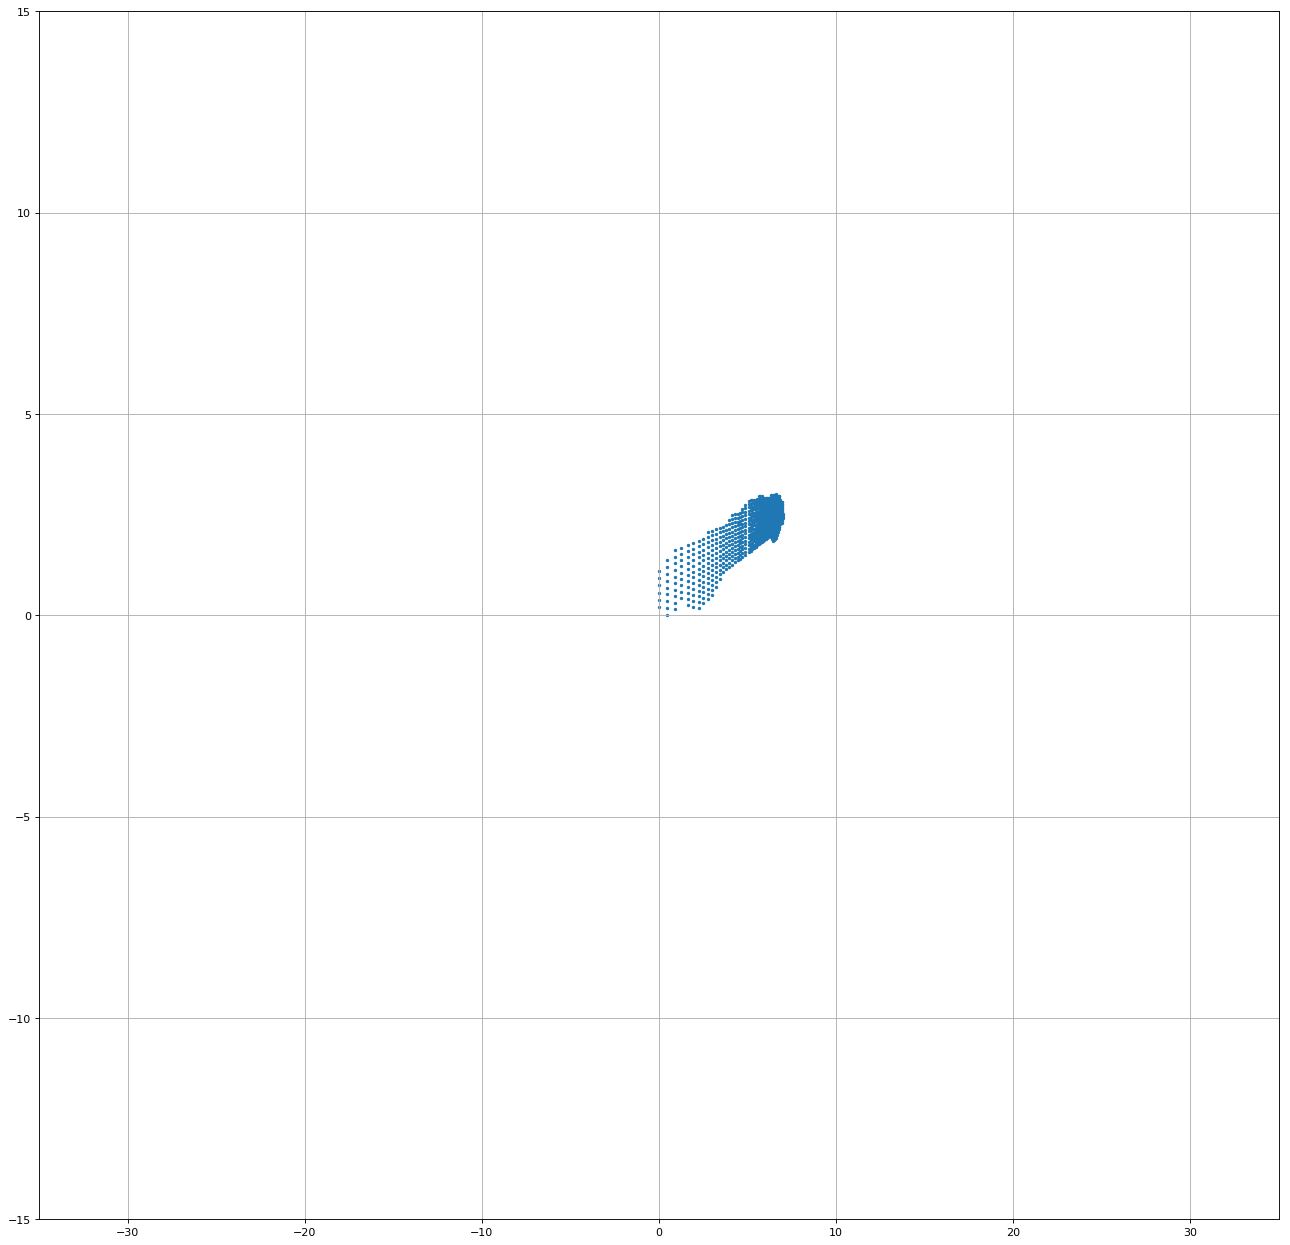

In [10]:
# Get Each scene and work on it, scene selected 6
scene_df = helper_object_points(no_outliers[6], 4)
# Apply projection
proj_df = project(scene_df, 5,view="Z")
# Apply normalization 
proj_df = normalize(proj_df)
# Plot the transformation
plot_g(7*proj_df['_x'],3*proj_df['_y'],(-35,35),(-15,15))

In [11]:
# Experiment with Test data 
no_outliers = get_data("test", "Set2", num_scenes=500)

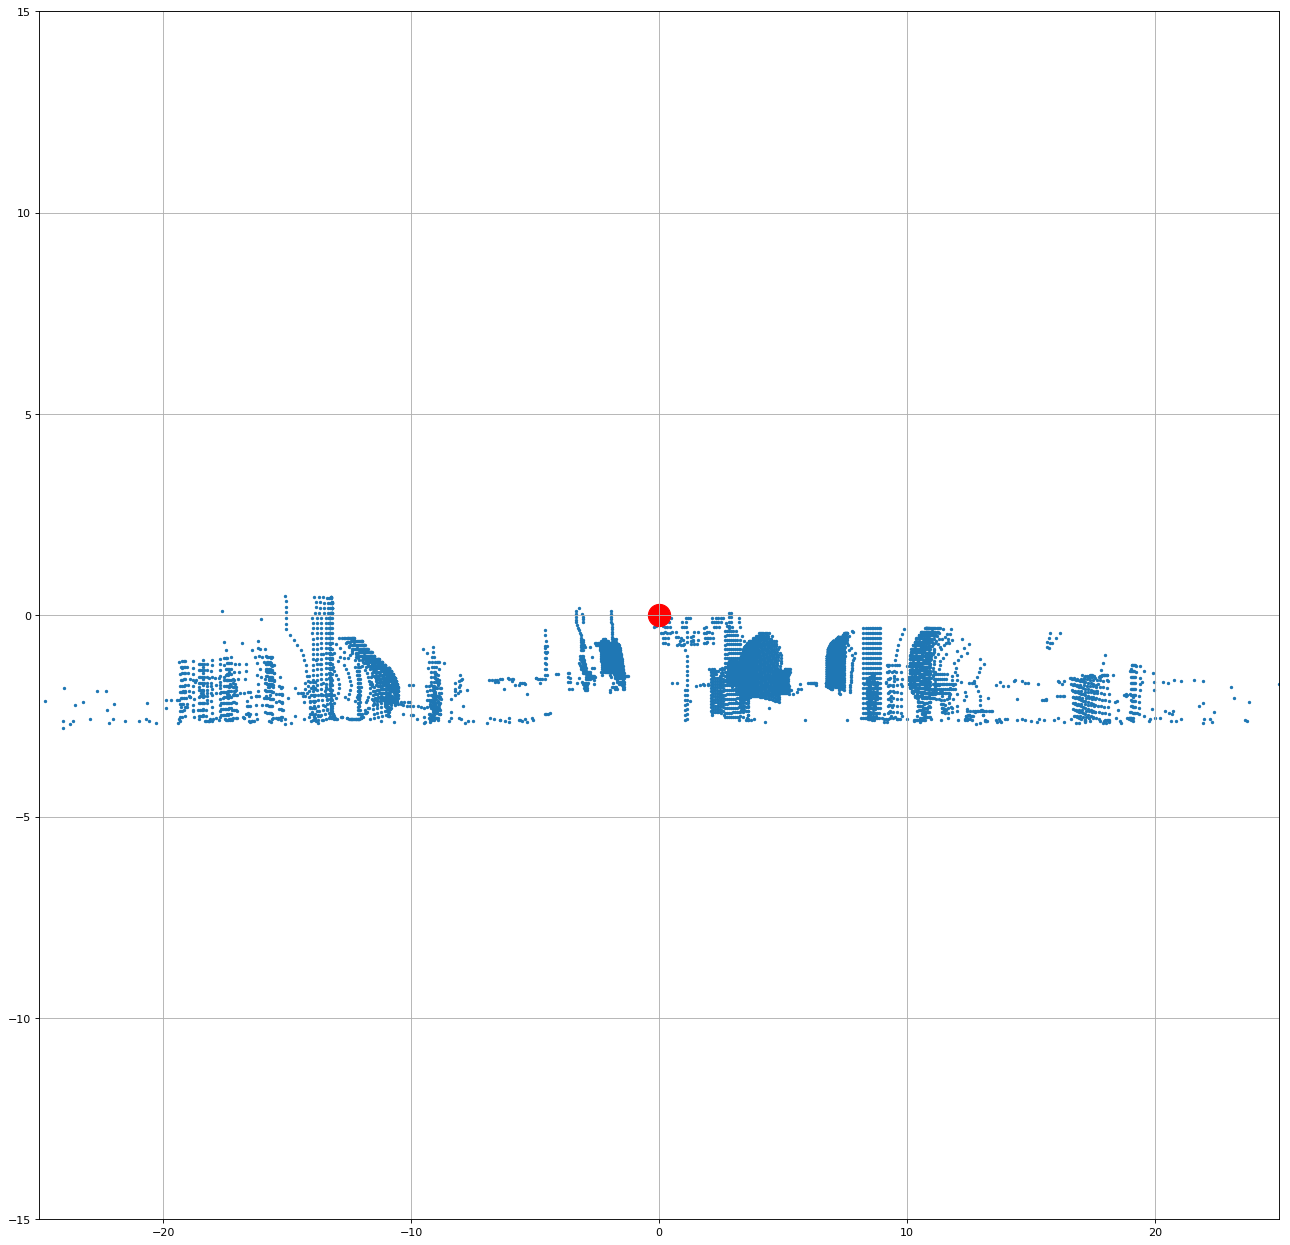

In [12]:
# Get the data for a scene - 6 
scene_df = helper_object_points(no_outliers[6], 4)

# Apply projection
# proj_df = project(scene_df, 5)

# Apply normalization
# proj_df = normalize(proj_df)

# Plot 
plot_g(scene_df['Z'],scene_df['Y'],(-25,25),(-15,15),centroid=True)

In [13]:
# Plot 3d points with plotly 
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
plotly.offline.init_notebook_mode(connected=True)

def plot_plotly(x,y,z):
    trace = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(color='rgb(0, 0, 0)',size=2,opacity=0.6))
    data = [trace]
    layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4, range = [-100,100],),
                    yaxis = dict(
                        nticks=4, range = [-50,100],),
                    zaxis = dict(
                        nticks=4, range = [-100,100],),)
                  )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='simple-3d-scatter')

Number of sectors: 29


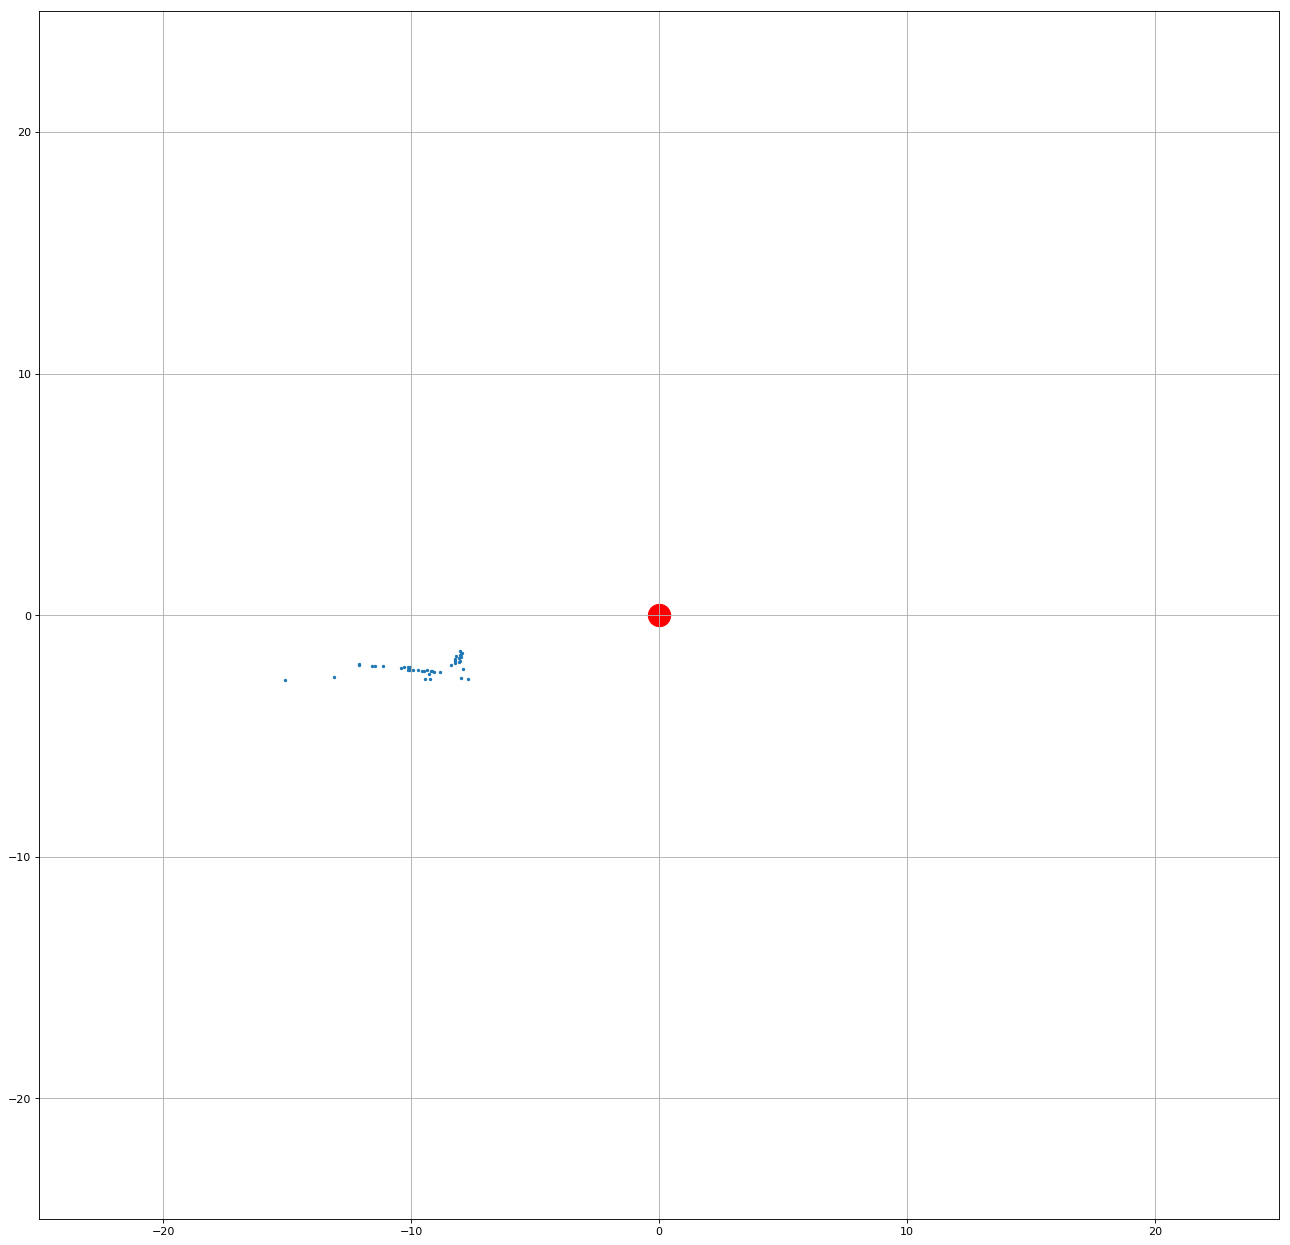

In [14]:
import math
# calculating degree
calDegrees=lambda x : round(math.degrees(math.atan(x)), 1)
vfunc = np.vectorize(calDegrees)
def tang(x,y):
    """ Get Tan inverse of y/x to get the angle."""
    tag= np.divide(y, x)
    return tag

def get_degrees(c):
    """ Get the degree for the data based upon cordinate plane.
    Tan behaviour in cordinate system.
    1st cord: theta
    2nd cord: 180+theta
    3rd cord: 180+theta
    4th cord: 360-theta
    return: degree of dataframe rows
    """
    degrees =  vfunc(tang(c['X'],c['Z']))
    if (c['X']<0 and c['Z']>0) or(c['X']<0 and c['Z']<0):
        degrees = 180+degrees
    if (c['X']>0 and c['Z']<0):
        degrees = 360-degrees
    return degrees

# Using Dataframe apply, a func is run on dataframe, pass the datafram to get_degrees
scene_df['angles'] = scene_df.apply(get_degrees,axis=1)


def stock_sectors(degr, stock,interval = 0.7):
    """ Split the degree in sectors based upon on the gap.
    params: degr=sorted list of unqiue degrees
            stock=List which contains the ranges of degree of a sector
            interval=step range of degree for look up 
    return stock=list contain the ranges of degree of a sector
    """
    sector= [degr[0]]
    for i in range(1, len(degr)):
        if degr[i]-degr[i-1]>interval:
            stock.append(sector)
            sector = []
        sector.append(degr[i])
    stock.append(sector)
    return stock

# convert the numpy array in list
deg = [float(d) for d in scene_df['angles']]
s = []
# apply the sorting
sorted_degrees = sorted(list(set(deg)))
# apply the stock_sector for breaking the sectors
s = stock_sectors(sorted_degrees,s)
print("Number of sectors:",len(s))

# Experiment with a sector, sector selected=18 
each_s=s[18]
after_df = scene_df[scene_df['angles'] < max(each_s)] 
after_df = after_df[after_df['angles'] > min(each_s)]

plot_g(after_df['Z'],after_df['Y'],(-25,25),(-25,25),centroid=True)

In [15]:
# Plot with plotly 
x = tuple(after_df['X'].tolist())
y = tuple(after_df['Y'].tolist())
z = tuple(after_df['Z'].tolist())

plot_plotly(x,y,z)

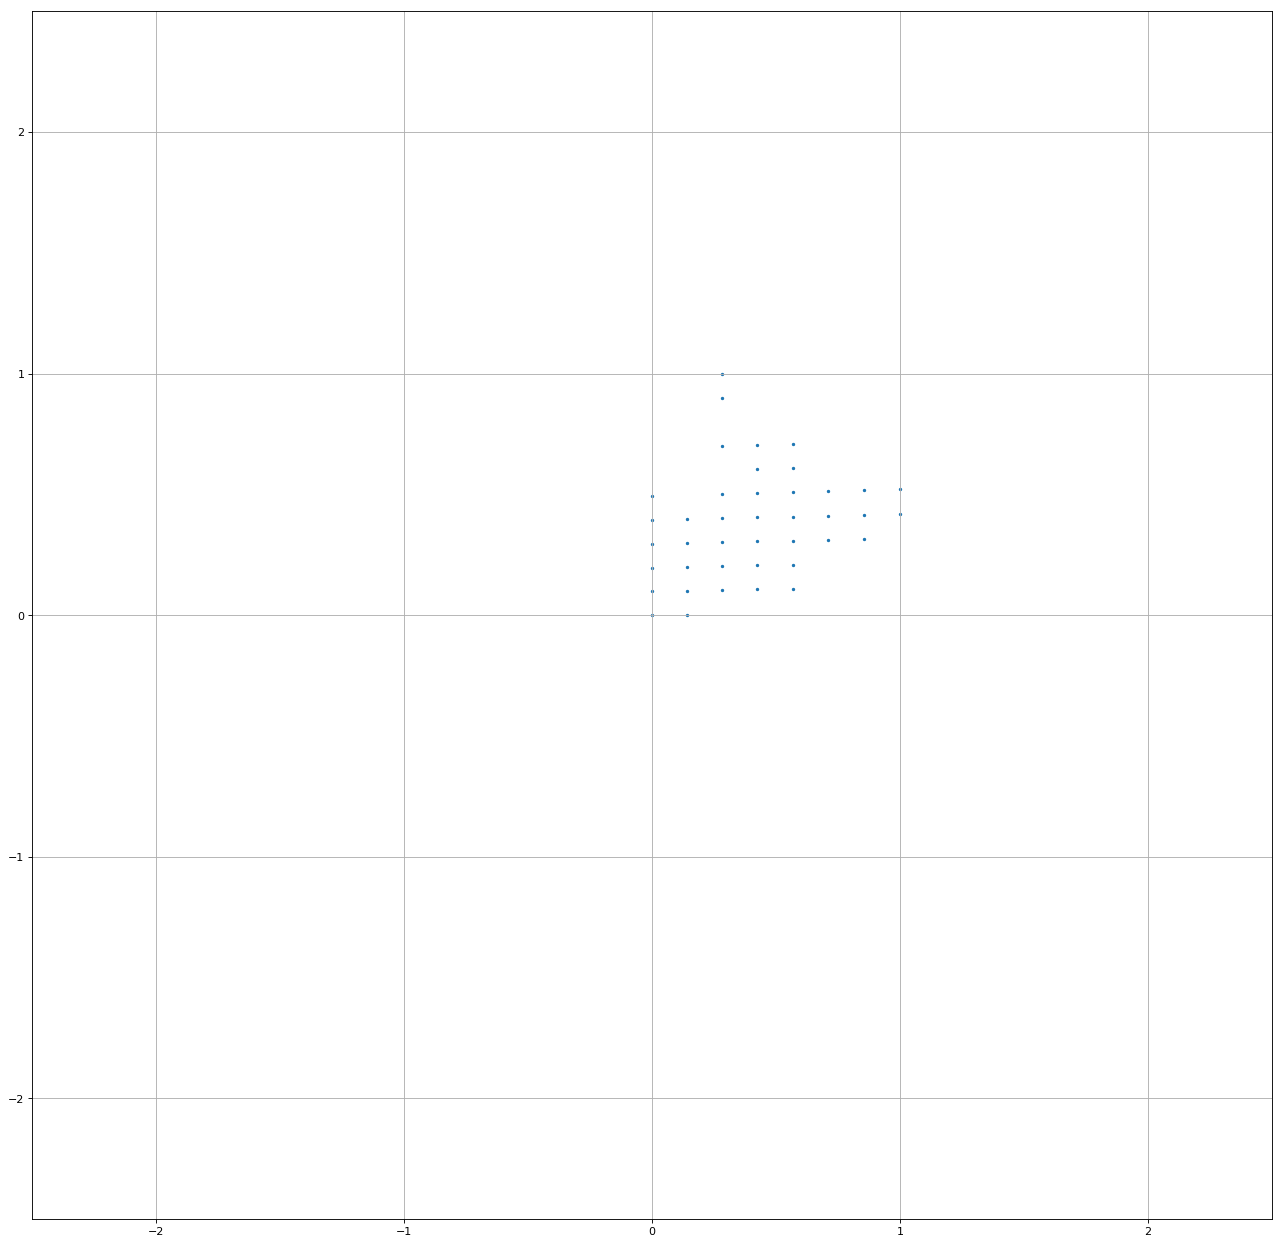

In [16]:
# apply projections
proj_df = project(after_df,4,view="X")
# apply normalization
proj_df = normalize(proj_df)
# plot
plot_g(proj_df['_x'],proj_df['_y'],(-2.5,2.5),(-2.5,2.5))

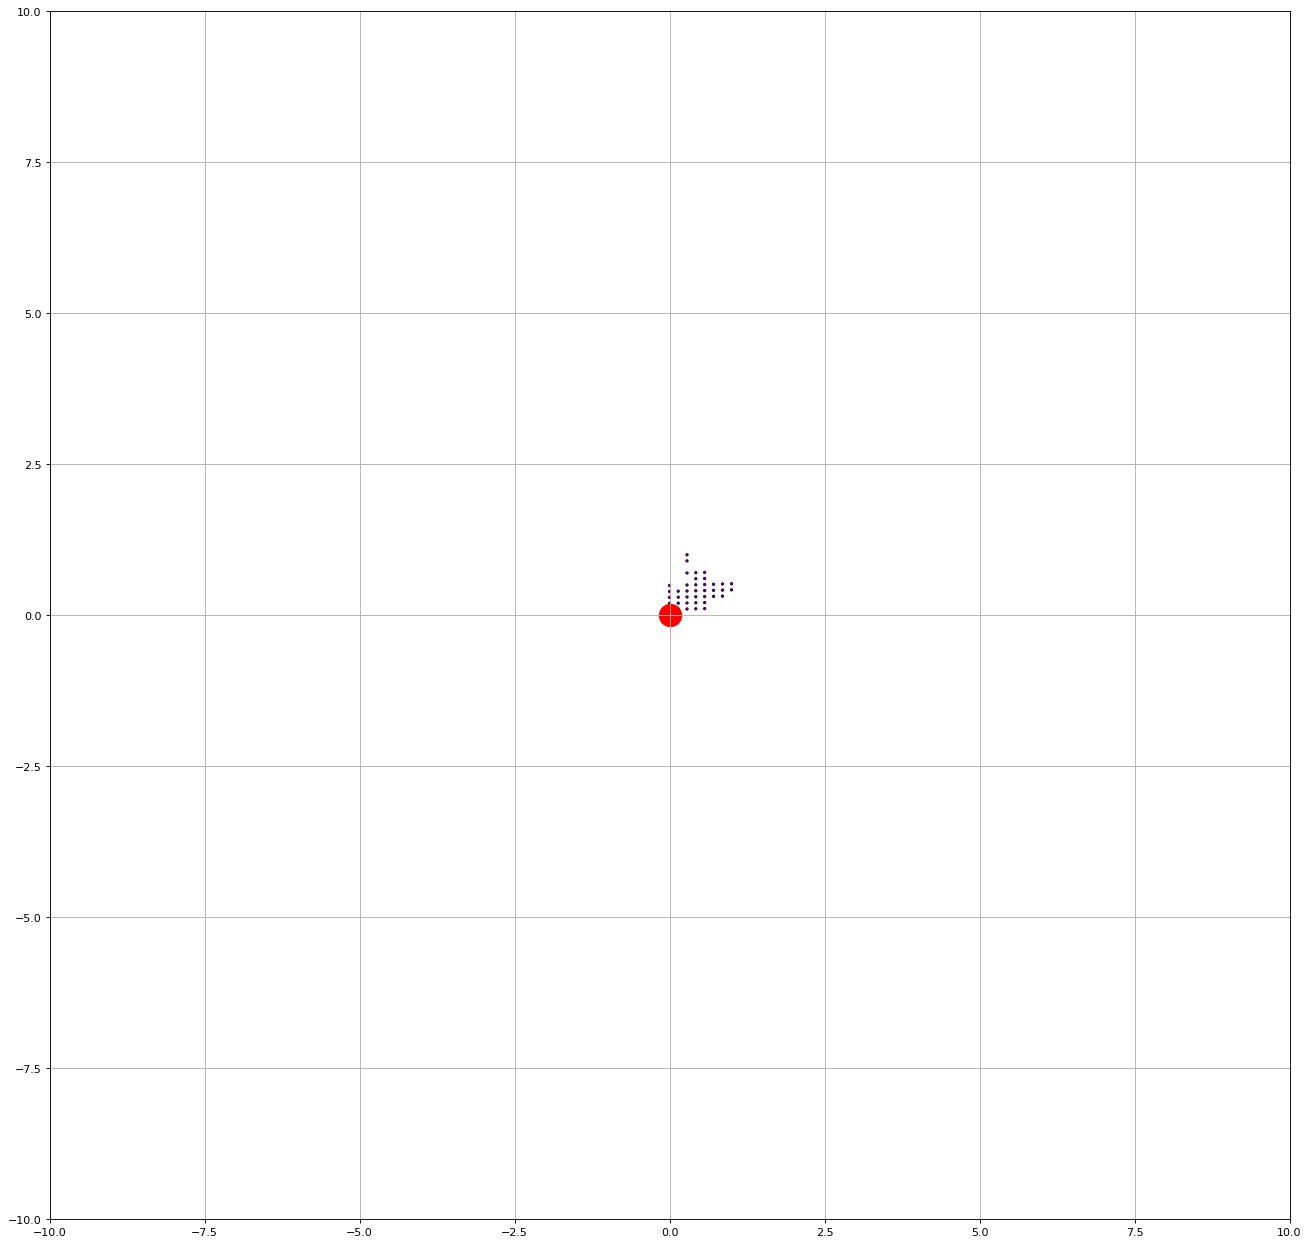

In [17]:
# format data for clustering
formatted_=format_data(proj_df)

# cluster using dbscan
labels = _cluster(formatted_)

# trick for bypassing outlier error  
labels=[i if i>0 else 999 for i in labels]

# Plot
plot_g(proj_df['_x'],proj_df['_y'],(-10,10),(-10,10),c=labels,centroid=True)

In [18]:
def get_output(object_type,object):
    """ Gather the original output from out.csv.
    params: object: object name 
            object_type: train or test
    return clus: list containing number of object per scene
    """
    output_path = "../{}/{}/out.csv".format("dataset/{}".format(object_type), object)
    out_file = open(output_path, 'r').readlines()
    outfile = [i.rstrip() for i in out_file]
    outfile = [i.split(',') for i in outfile]
    outfile = [i[1:] for i in outfile]

    outfile_list = []
    out_cluster = []
    for i in outfile:
        a  = {}
        for j in range(0,len(i),2):
            a[i[j]] = int(i[j+1])
        out_cluster.append(sum(a.values()))
        outfile_list.append(a)
    return outfile_list, out_cluster

# Output of set2
_, clus = get_output("test", "Set2")

In [ ]:
# Comparision between set2 with sector based clustering and original out:
# Experiment with Test data 
no_outliers = get_data("test", "Set2", num_scenes=50)
for i in range(50):
    # get scene
    scene_df = helper_object_points(no_outliers[i], 4)
    scene_df['angles'] = scene_df.apply(get_degrees,axis=1) # get_degrees is a func, scene_df is params
    deg = [float(d) for d in scene_df['angles']] 
    s = []
    sorted_degrees = sorted(list(set(deg)))
    s = stock_sectors(sorted_degrees,s)
    print("Number of sectors:",len(s))
    total_clusters = 0
    for each_s in s:
        # sector with one point is to be neglected.
        if len(each_s) > 2:
            after_df = scene_df[scene_df['angles'] <= max(each_s)] 
            after_df = after_df[after_df['angles'] >= min(each_s)]
            proj_df = project(after_df,4,view="X")
            proj_df = normalize(proj_df)
            formatted_=format_data(proj_df)
            labels = _cluster(formatted_)
            total_clusters += len(set(labels))
    print("Original {}, cluster {}, difference {}".format(clus[i], total_clusters, clus[i]-total_clusters))

Number of sectors: 30
Original 33, cluster 29, difference 4
Number of sectors: 26
Original 25, cluster 25, difference 0
Number of sectors: 24
Original 25, cluster 22, difference 3
Number of sectors: 17
Original 17, cluster 17, difference 0
Number of sectors: 19
Original 16, cluster 18, difference -2
Number of sectors: 28
Original 34, cluster 25, difference 9
Number of sectors: 29
Original 35, cluster 28, difference 7
Number of sectors: 26
Original 20, cluster 21, difference -1
Number of sectors: 7
Original 17, cluster 6, difference 11
Number of sectors: 26
Original 32, cluster 25, difference 7
Number of sectors: 28
Original 39, cluster 26, difference 13
Number of sectors: 27
Original 47, cluster 27, difference 20
Number of sectors: 16
Original 40, cluster 14, difference 26
Number of sectors: 13
Original 12, cluster 13, difference -1
Number of sectors: 17
Original 19, cluster 17, difference 2
Number of sectors: 22
Original 26, cluster 20, difference 6
Number of sectors: 4
Original 16, c

Factors contributing in above difference: sector_interval=0.7,dbscan.eps, dbscan.min_sample.